Today we will construct some software to model charge-transfer reactions.

We will do this using the Butler-Volmer form:

$$i = i_\circ\left[\exp\left(\frac{\beta_{\rm fwd} F\eta}{RT}\right) - \exp\left(-\frac{\beta_{\rm rev} F\eta}{RT}\right)\right]$$

We will model this for a PEMFC full-cell reaction:

$${\rm H_2 + \frac{1}{2}O_2 \leftrightharpoons H_2O}$$ 

at 25$^\circ$C with humidified H$_2$ (i.e. $X_{H_2O} = 0.03$) and air in the cathode.

We will model this using the simplest possible model: assuming fixed gas phase composition and zero transport limitations (i.e. 'flooded cell').

In this model, the only state variables are the electric potentials:

- The anode potential, $\phi_{\rm an}$,
- The cathode potential, $\phi_{\rm ca}$, and
- The electrolyte potential, $\phi_{\rm elyte}$,

(again, assuming no transport limitations, we assume there is just a single $\phi_{\rm elyte}$ value). Because all $\phi$ values are relative, we even get to pick one of these to be zero.  Let's choose the most negative potential, $\phi_{\rm an}$.  All potentials are now relative to $\phi_{\rm an}$.  Our solution vector might be written as:

$$ SV=\begin{bmatrix} \phi_{\rm elyte} \\ \phi_{\rm ca}\end{bmatrix}$$

From our conservation of charge, the variables we will actually calculate are the two double-layer voltages, $\Delta\phi_{\rm dl,an}$ and $\Delta\phi_{\rm dl,ca}$, where:
\begin{equation}
\Delta\phi_{\rm dl,an} = \phi_{\rm elyte} - \phi_{\rm an}
\end{equation}
and
\begin{equation}
\Delta\phi_{\rm dl,ca} = \phi_{\rm ca} - \phi_{\rm elyte}
\end{equation}
Given the assumption $\phi_{\rm an} = 0$, solving for these two variables is equivalent to solvin for the $SV$ above:
$$ SV=\begin{bmatrix} \Delta\phi_{\rm dl,an} \\ \Delta\phi_{\rm dl,ca}\end{bmatrix}$$

Let's initialzie our model with some guess values, and integrate it with respect to time for a case where _nothing happens_.

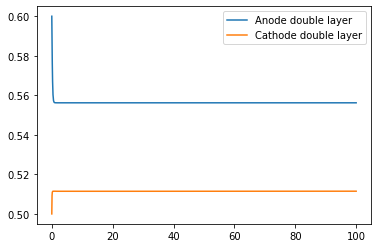

In [88]:
from scipy.integrate import solve_ivp
import numpy as np
from matplotlib import pyplot as plt
from math import exp

phi_an = 0
phi_elyte_0 = 0.6
phi_ca_0 = 1.1

C_dl_an = 1e2 # F/m2
C_dl_ca = 1e2 # F/m2

i_o_an = 2.5
i_o_ca = 1
n_an = 2
n_ca = 4
F = 96485
beta_ca = 0.5
beta_an = 0.5
R = 8.3145
T = 298

delta_Phi_eq_an = 0.61
delta_Phi_eq_ca = 0.55

i_ext = 20

SV_0 = np.array([phi_elyte_0 - phi_an, phi_ca_0 - phi_elyte_0])
time_span = np.array([0,100])

# define a derivative. 
def residual(t,SV):
    dSV_dt = np.zeros_like(SV)
    
    eta_an = SV[0] - delta_Phi_eq_an
    i_Far_an = i_o_an*(exp(-n_an*F*beta_an*eta_an/R/T)
                      - exp(n_an*F*(1-beta_an)*eta_an/R/T))
    i_dl_an = i_ext - i_Far_an
    dSV_dt[0] = -i_dl_an/C_dl_an
    
    
    eta_ca = SV[1] - delta_Phi_eq_ca
    i_Far_ca = i_o_ca*(exp(-n_ca*F*beta_ca*eta_ca/R/T)
                      - exp(n_ca*F*(1-beta_ca)*eta_ca/R/T))
    i_dl_ca = i_ext - i_Far_ca
    
    
    dSV_dt[1] = -i_dl_ca/C_dl_ca
    return dSV_dt

solution = solve_ivp(residual,time_span,SV_0,rtol=1e-4, atol=1e-6)

for var in solution.y:
    plt.plot(solution.t,var)
    
plt.legend(['Anode double layer','Cathode double layer'])

We might rather plot this as the actual voltages.  We can do this in post-processing:

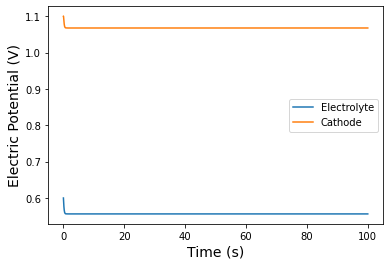

In [89]:
V_elyte = solution.y[0,:]
V_ca = V_elyte + solution.y[1,:]
plt.plot(solution.t,V_elyte)
plt.plot(solution.t,V_ca)

plt.xlabel('Time (s)',fontsize=14)
plt.ylabel('Electric Potential (V)',fontsize=14)
plt.legend(['Electrolyte','Cathode'])

Next, we need a governing equation for each variable.  Given an external current $i_{\rm ext}$, which moves positive charge from cathode to anode, charge neutrality dictates, for the anode:

$$i_{\rm ext} - i_{\rm Far,an} -i_{\rm dl,an} = 0$$

where $i_{\rm Far}$ is charge transfer current from the anode to the electrolyte, and $i_{\rm dl,an}$ is the anode double layer current - positive charge moved to the anode side of the double layer from the anode bulk.  If $i_{\rm ext}$ and $i_{\rm Far}$ are not equal, then $i_{\rm dl}$ changes the double layer potential to bring them in line.  The double layer id modeled as a capacitor, where:

$$C_{\rm dl,an} = \frac{Q_{\rm dl,.an}}{\Delta \phi_{\rm dl,an}}$$

if we rearrange and take the derivative w/r/t time, we get a differntial equation:

$$\frac{\partial \Delta\phi_{\rm dl,an}}{\partial t} = \frac{dQ_{\rm dl,an}}{dt}\frac{1}{C_{\rm dl,an}} = \frac{i_{\rm dl,an}}{C_{\rm dl,an}}$$

with

$$i_{\rm dl,an} = i_{\rm ext} - i_{\rm Far,an}$$

Simiarly, we can derive for the cathode:

$$\frac{\partial \Delta\phi_{\rm dl,ca}}{\partial t} = \frac{i_{\rm dl,ca}}{C_{\rm dl,ca}}$$

where 

$$i_{\rm dl,ca} = i_{\rm ext} - i_{\rm Far,ca}.$$

In this case, $i_{\rm dl,ca}$ and $i_{\rm Far,ca}$ represent positive charge transferred _to the cathode_.

To solve our system of equations, then, it is only necessary (for now!) that we know how to calculate $i_{\rm Far}$ at each interface!  Which is the subject of your Homework 4!  Joy!!!

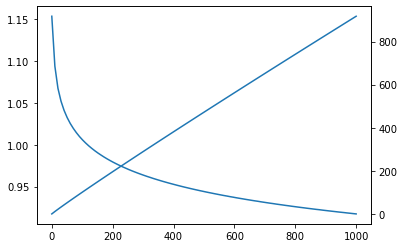

In [3]:
from scipy.integrate import solve_ivp
import numpy as np
from matplotlib import pyplot as plt
from math import exp

def PEMFC_func(i_ext, SV_0, plot_flag):
    C_dl_an = 1e4 # F/m2
    C_dl_ca = 1e4 # F/m2

    i_o_an = 2.5
    i_o_ca = 1
    n_an = 2
    n_ca = 4
    F = 96485
    beta_ca = 0.5
    beta_an = 0.5
    R = 8.3145
    T = 298

    delta_Phi_eq_an = 0.61
    delta_Phi_eq_ca = 0.55

#     SV_0 = np.array([phi_elyte_0 - phi_an, phi_ca_0 - phi_elyte_0])
    time_span = np.array([0,100])

    # define a derivative. 
    def residual(t,SV):
        dSV_dt = np.zeros_like(SV)

        # Anode Interface:
        eta_an = SV[0] - delta_Phi_eq_an
        i_Far_an = i_o_an*(exp(-n_an*F*beta_an*eta_an/R/T)
                          - exp(n_an*F*(1-beta_an)*eta_an/R/T))
        i_dl_an = i_ext - i_Far_an
        dSV_dt[0] = -i_dl_an/C_dl_an

        # Cathode Interface:
        eta_ca = SV[1] - delta_Phi_eq_ca
        i_Far_ca = i_o_ca*(exp(-n_ca*F*beta_ca*eta_ca/R/T)
                          - exp(n_ca*F*(1-beta_ca)*eta_ca/R/T))
        i_dl_ca = i_ext - i_Far_ca


        dSV_dt[1] = -i_dl_ca/C_dl_ca
        return dSV_dt

    solution = solve_ivp(residual,time_span,SV_0,rtol=1e-4, atol=1e-6)

    V_elyte = solution.y[0,:]
    V_ca = V_elyte + solution.y[1,:]
    if plot_flag:
        plt.plot(solution.t,V_elyte)
        plt.plot(solution.t,V_ca)

        plt.xlabel('Time (s)',fontsize=14)
        plt.ylabel('Electric Potential (V)',fontsize=14)

        plt.legend([r'$\phi_{\rm elyte}$',r'$\phi_{\rm cathode}$'],fontsize=14,frameon=False)
   
    return solution.y[:,-1]
    
#from PEMFC_function import PEMFC_func

i_array = np.linspace(0, 1000, 100)
V_cell = np.zeros_like(i_array)

SV_0 = np.array([0.6, 0.5])

SV = np.zeros((SV_0.size,i_array.size))
for j,i_ext in enumerate(i_array):
    plot = 0
    SV[:,j] = PEMFC_func(i_ext, SV_0, plot)
    SV_0 = SV[:,j]

V_cell = SV[0,:] + SV[1,:]

fig, ax1 = plt.subplots()
ax1.plot(i_array,V_cell) 
ax2 = ax1.twinx()
ax2.plot(i_array,V_cell*i_array)

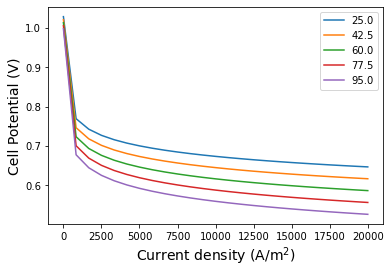

In [4]:
# pemfc_temp_study
import numpy as np
from pemfc_polarization import polarization
from matplotlib import pyplot as plt

# Define temperatures to test
T_range = np.linspace(298.15,368.15,5)

for T in T_range:
    i, V = polarization(T)
    plt.plot(i, V)

plt.legend(T_range-273.15)
plt.xlabel('Current density (A/m$^2$)',fontsize=14)
plt.ylabel('Cell Potential (V)',fontsize=14)
plt.savefig('polarization_vs_temperature.pdf',dpi=350)
plt.show()